# Questão 3

# Dado o arquivo invoices.csv escreva um serviço que computa a média de faturamento de cada conta (account) nos últimos três e seis meses retroativos à Jan/2020. Quando não há dados suficientes na janela de 3 ou 6 meses o serviço registra a entrada como NaN (null).  A saída esperada é a seguinte: 



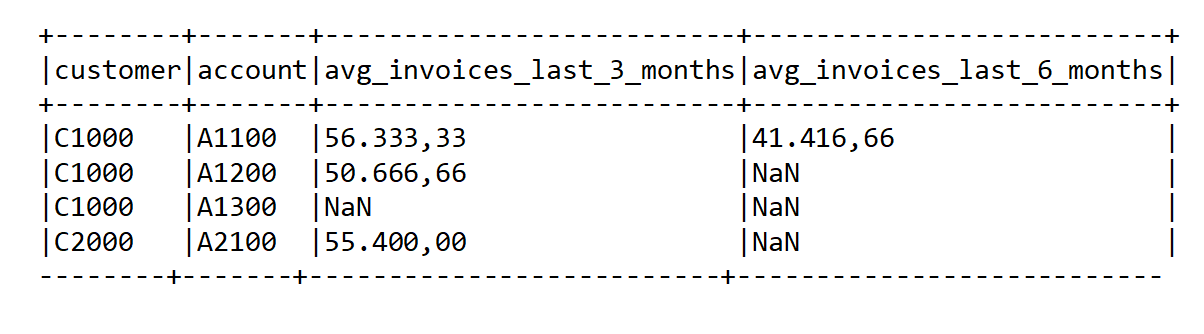


# Import Bibliotecas

In [1]:
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import datetime 
from pyspark.sql.types import * 
from pyspark.sql.functions import * 

# Criando um Sessão no Spark

In [ ]:
spark = SparkSession \
    .builder \
    .appName("Desafio STITDATA") \
    .getOrCreate()

# Criando as variaveis que recebem os path referentes aos arquivos que seram carregado no datafrane


In [ ]:
path_invoces_csv = 'C:/Users/Dell/Desktop/Desafio_STITDATA/data-engineer-master/invoices.csv'

path_hour13_json = 'C:/Users/Dell/Desktop/Desafio_STITDATA/data-engineer-master/hour=13.json'

path_hour14_json = 'C:/Users/Dell/Desktop/Desafio_STITDATA/data-engineer-master/hour=14.json'

# Carregando arquivo CSV em um dataframe e realizado tratamento em colunas

In [ ]:
dfInvoces = spark.read.option("header", True)\
                        .option("inferSchema", True)\
                        .csv(path_invoces_csv)\
                        .withColumn("month", to_date("month","yyyy-MM-dd"))\
                        .withColumn("invoice", regexp_replace("invoice", "\\,", ".").cast("Double").alias('cost'))\

# Imprimindo schema

In [ ]:
dfInvoces.printSchema()

# Visualizando o Dataframe

In [ ]:
dfInvoces.show()

# Visualizando os dados há 3, 6 meses passados

In [ ]:
(dfInvoces
.groupBy("customer", "account").agg(
    avg(when(col("month") > '2020-01-01' - expr("INTERVAL 4 month"),col('invoice'))).cast("decimal(9,2)").alias('avg_invoices_last_3_months'),
    avg(when(col("month") > '2020-01-01' - expr("INTERVAL 7 month"),col('invoice'))).cast("decimal(9,2)").alias('avg_invoices_last_6_months')
  )
.orderBy('account')
.show())

# Carregando arquivo json no dataframe

In [ ]:
dfHour13 = spark.read.option("multiline","true").json(path_hour13_json).withColumn("timestamp", to_timestamp(substring(regexp_replace('timestamp',  "T", " "), 1, 19), "yyyy-MM-dd HH:mm:ss"))\

# Selecionando os dados do dataframe

In [ ]:
dfHour13Select = dfHour13.select("customer", "flow", "session", "timestamp", "content.cpf", "content.name", "content.recomenda")

# Carregando arquivo json no dataframe

In [ ]:
dfHour14 = spark.read.option("multiline","true").json(path_hour14_json).withColumn("timestamp", to_timestamp(substring(regexp_replace('timestamp',  "T", " "), 1, 19), "yyyy-MM-dd HH:mm:ss"))\

# Imprimindo schema

In [ ]:
dfHour14.printSchema()

# Visualizado os dados do dataframe

In [ ]:
dfHour14.show()

# Selecionando os dados do dataframe

In [ ]:
dfHour14Select = dfHour14.select("customer", "flow", "session", col("timestamp").alias("timestamp14"), col("content.cpf").alias("cpf14"), "content.delivery_confirmed", "content.nota")

# Visualizando dados do dataframe

In [ ]:
dfHour14Select.show()

In [ ]:
dfHour13Select.show()

# Join entre os dataframe referente aos dados hour=13.json  e hour=14.json

In [ ]:
dfJoinHour = dfHour13Select.join(dfHour14Select, on=['customer', 'session', 'flow'], how = 'inner')

# Visualizaado novo dataframe

In [ ]:
dfJoinHour.show()

# Eliminando colunos que não serão usadas, criando nova coluna 

In [ ]:
dfJoinHour = dfJoinHour.drop("cpf", "cpf14")

dfJoinHour = dfJoinHour.withColumn("cpf",
                         when((col("customer") == 'C1000') & (col("session") == 'S1000'),"305.584.960-40")
                         .when((col("customer") == 'C1000') & (col("session") == 'S2000'),"733.600.420-26"))

# Visualizando dataframe

In [ ]:
dfJoinHour.show()

# Consulta referente a first_answer_dt e last_answer_dt last_answer_dt e adicionando o resultado em outro dataframe

In [ ]:
dfGroupBy = dfJoinHour.groupBy("customer","session").agg(
    min("timestamp").alias('first_answer_dt'),
    max("timestamp14").alias('last_answer_dt'))

# Visualizando dataframe com a consulta

In [ ]:
dfGroupBy.show()

# Join

In [ ]:
dfJoinGroupBy = dfJoinHour.join(dfGroupBy, on=['customer', 'session'], how = 'inner').select(dfJoinHour.customer, "flow",dfJoinHour.session, "first_answer_dt", "last_answer_dt", "cpf", "name", "recomenda", "nota").distinct()

# Visualização de dados

In [ ]:
dfJoinGroupBy.show()